# 大月亮的机器学习实战

## 1. 导入库及设定

In [1]:
# Data
import numpy as np
import pandas as pd

# Image
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# Machine-learning

## Model
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

## Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

## Model metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Others

## Creat Tree Image
from sklearn import tree
import pydotplus
from IPython.display import Image

## Config warnings
import warnings

# Settings
warnings.filterwarnings('ignore')
pd.set_option('precision', 2)
pd.options.display.max_columns = None # Show all columns
pd.options.display.max_rows = None # Show all columns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## 2. 读取数据

In [2]:
datafile = 'moon.xlsx'
data = pd.read_excel(datafile)

## 3. 数据描述

### 3.1 基本数据形式

In [3]:
data.head()

,Label,Stage,Luminal,Risk,Age,Menopause,MBNG,T,N,M,ER,PR,Her2,Ki67,Infiltration
0,0,3,1,1,2,0,3,2,1,0,1,1,1,1,0
1,0,1,2,1,2,0,2,1,0,0,1,1,1,2,0
2,0,2,1,1,3,0,2,1,1,0,1,1,1,1,1
3,1,3,4,2,3,1,3,2,3,0,0,0,3,2,1
4,0,2,5,1,3,1,3,2,0,0,0,0,1,2,0


### 3.2 相关热图

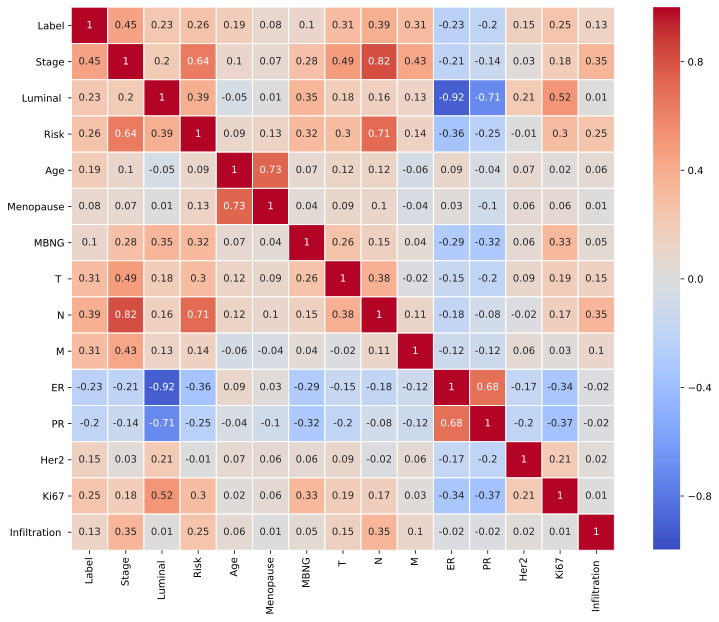

In [4]:
plt.figure(figsize=(14,10))
sns.heatmap(round(data.corr(),2), linewidths=1, square=True, cmap='coolwarm', 
            linecolor='white', annot=True, vmax=1, vmin=-1);
# plt.savefig('Heatmap.svg')

### 3.3 其他描述

好多种方法都可以使用，可逐项分析整体和各项特征

## 4. 数据分离

In [5]:
seed = 1
testsize = 0.2
kfold = StratifiedKFold(n_splits=10, random_state =seed)
X, y = data.values[:,1:], data.values[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=seed)

## 5. 模型选择

### 5.1 初步筛选，决定使用决策树模型

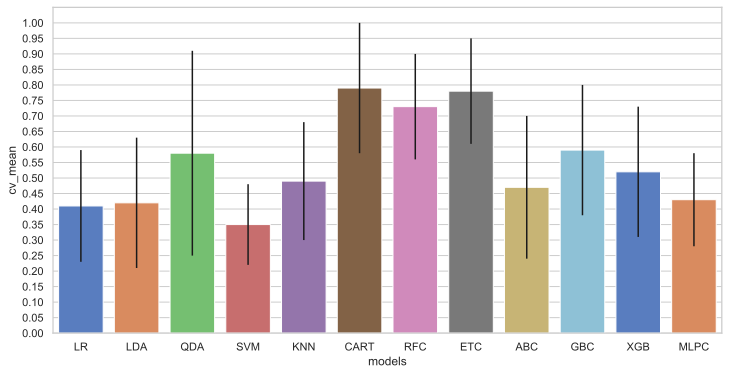

In [6]:
models = {
    'LR'  : LogisticRegression(),
    'LDA' : LinearDiscriminantAnalysis(),
    'QDA' : QuadraticDiscriminantAnalysis(),
    'SVM' : SVC(),
    'KNN' : KNeighborsClassifier(),
    'CART': DecisionTreeClassifier(random_state=seed),
    'RFC' : RandomForestClassifier(random_state=seed),
    'ETC' : ExtraTreesClassifier(random_state=seed),
    'ABC' : AdaBoostClassifier(),
    'GBC' : GradientBoostingClassifier(random_state=seed),
    'XGB' : XGBClassifier(),
    'MLPC': MLPClassifier(random_state=seed)
}

cv_results = []
for key in models: 
        cv_score = cross_val_score(models[key], X_train, y_train, cv=kfold, scoring="recall")
        cv_mean = round(cv_score.mean(), 2)
        cv_std = round(cv_score.std(), 2)
        cv_result = {'models': key, 'cv_mean': cv_mean, 'cv_std': cv_std}
        cv_results.append(cv_result)
cv_results = pd.DataFrame(cv_results)

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
cv_plot = sns.barplot(x='models', y='cv_mean', data=cv_results, palette="muted", **{'yerr': cv_results['cv_std']});
cv_plot.set_yticks(np.arange(0, 1.05, 0.05));
# plt.savefig('Model_Selection.svg')

### 5.2 评估“所有数据，仅基础数据，仅分期分型风险数据”对结果的影响分析，选择使用整体数据，此处可商量

In [7]:
cv_results = []

key = 'CART' 

# All data
cv_score = cross_val_score(models[key], X_train, y_train, cv=kfold, scoring="recall")
cv_mean = round(cv_score.mean(), 2)
cv_std = round(cv_score.std(), 2)
cv_result = {'models': key, 'cv_mean': cv_mean, 'cv_std': cv_std, 'type': 'ALL'}
cv_results.append(cv_result)

# ONLY USE TNM,HR,KI67,HER2
cv_score = cross_val_score(models[key], X_train[:, 3:], y_train, cv=kfold, scoring="recall")
cv_mean = round(cv_score.mean(), 2)
cv_std = round(cv_score.std(), 2)
cv_result = {'models': key, 'cv_mean': cv_mean, 'cv_std': cv_std, 'type': 'BASE'}
cv_results.append(cv_result)

# ONLY USE STAGE, LUMINAL, RISK
cv_score = cross_val_score(models[key], X_train[:, :3], y_train, cv=kfold, scoring="recall")
cv_mean = round(cv_score.mean(), 2)
cv_std = round(cv_score.std(), 2)
cv_result = {'models': key, 'cv_mean': cv_mean, 'cv_std': cv_std, 'type': 'RISK'}
cv_results.append(cv_result)

cv_results = pd.DataFrame(cv_results)

cv_results

,models,cv_mean,cv_std,type
0,CART,0.79,0.21,ALL
1,CART,0.78,0.13,BASE
2,CART,0.36,0.14,RISK


### 5.3 调参，比较初始提高CV平均值，降低了标准差

In [8]:
parameters = {
                'max_depth': range(1,11),
                'max_features': range(1,15)
}

grid_init = GridSearchCV(models['CART'], param_grid=parameters, scoring='recall', cv=kfold)
grid_fit = grid_init.fit(X_train, y_train)
model = grid_fit.best_estimator_
cv_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring="recall")
cv_mean = round(cv_score.mean(), 2)
cv_std = round(cv_score.std(), 2)
print('cv_mean: ', cv_mean)
print('cv_std: ', cv_std)

cv_mean:  0.8
cv_std:  0.17


## 6. 校验模型

### 6.1 数据预测

In [9]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test) # 决策树的二分类每个点proba是0或者1
result = pd.DataFrame(X_test, columns=data.columns[1:])
result['label'] = y_test
result['pred'] = y_pred
result['result'] = y_pred - y_test
correct_data = result[result['result']==0]
wrong_data = result[result['result']!=0]

In [10]:
correct_data

,Stage,Luminal,Risk,Age,Menopause,MBNG,T,N,M,ER,PR,Her2,Ki67,Infiltration,label,pred,result
0,1,1,1,2,0,2,1,0,0,1,1,1,1,0,0,0,0
1,1,1,1,2,0,2,1,0,0,1,1,1,1,0,0,0,0
2,1,1,1,3,1,2,1,0,0,1,1,1,1,1,0,0,0
3,1,1,1,2,0,2,1,0,0,1,1,1,1,0,0,0,0
4,3,1,1,3,1,3,3,1,0,1,1,1,1,0,1,1,0
5,3,1,2,3,1,2,1,2,0,1,1,1,1,1,0,0,0
6,2,2,1,2,0,2,2,1,0,1,1,1,2,1,0,0,0
7,1,5,1,2,1,3,1,0,0,0,0,2,2,0,0,0,0
8,1,1,1,2,0,2,1,0,0,1,1,2,1,1,0,0,0
9,1,1,1,2,0,1,1,0,0,1,0,1,1,0,0,0,0


In [11]:
wrong_data

,Stage,Luminal,Risk,Age,Menopause,MBNG,T,N,M,ER,PR,Her2,Ki67,Infiltration,label,pred,result
21,2,5,1,2,0,2,3,0,0,0,0,2,2,0,0,1,1
43,3,1,2,3,1,2,2,3,0,1,1,2,1,1,0,1,1
57,2,1,1,3,1,2,2,0,0,1,0,1,1,0,1,0,-1
62,2,1,1,3,1,2,2,1,0,1,1,1,1,1,0,1,1
66,2,3,3,2,0,3,1,1,0,1,1,3,2,1,1,0,-1
68,3,1,3,3,0,2,1,2,0,1,1,1,1,1,1,0,-1
69,3,2,2,3,1,2,2,2,0,1,1,2,2,0,0,1,1
74,2,1,1,3,1,2,1,1,0,1,1,1,1,1,1,0,-1
75,2,2,2,3,1,3,2,1,0,1,1,2,2,1,1,0,-1


### 6.2 混淆矩阵

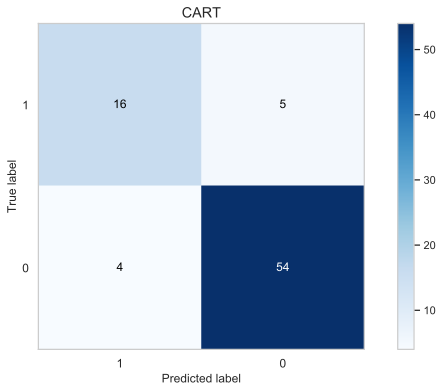

In [12]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False, labels=[1,0], figsize=(12,6), title=key);
# plt.savefig('Confusion_Matrix.svg')

### 6.3 分类评估报告

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92        58
           1       0.80      0.76      0.78        21

    accuracy                           0.89        79
   macro avg       0.86      0.85      0.85        79
weighted avg       0.88      0.89      0.89        79



### 6.4 特征重要性

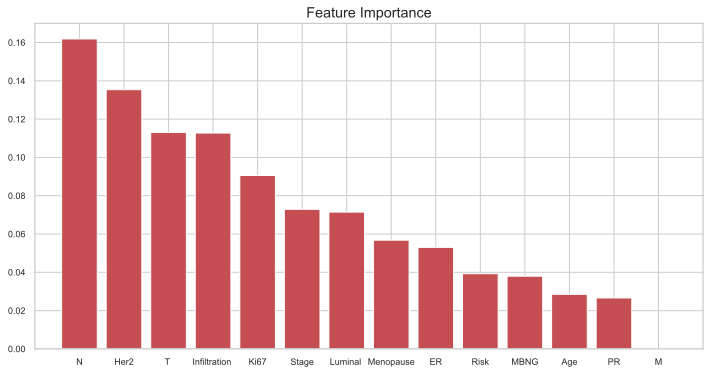

In [14]:
skplt.estimators.plot_feature_importances(model, feature_names=data.columns[1:], figsize=(12,6), text_fontsize=9);
# plt.savefig('Feature_Importance.svg')

### 6.5 树图

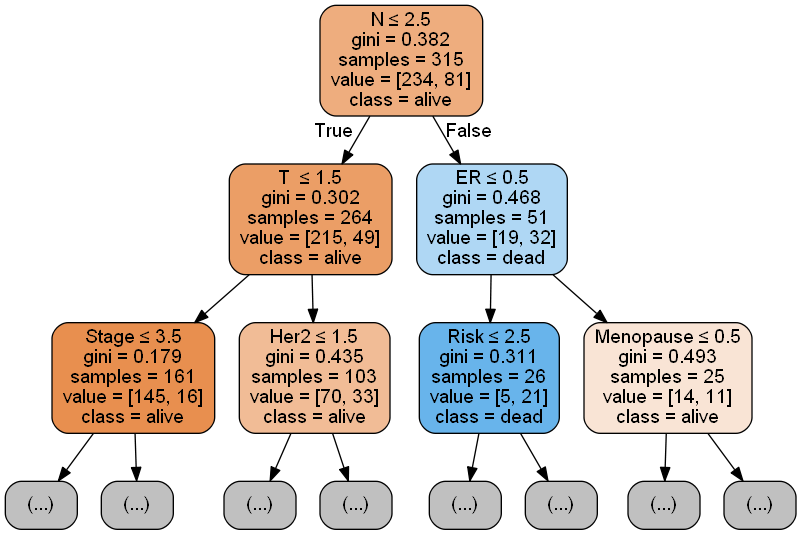

In [15]:
dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=data.columns[1:],  
                         class_names=['alive','dead'],  
                         filled=True, rounded=True,  
                         special_characters=True,
                         max_depth=2)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 
# graph.write_svg('CART_Tree.svg')

## 7. 效能评估

### 7.1 学习曲线

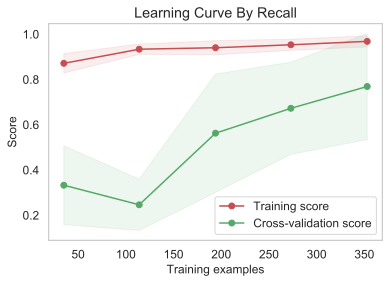

In [16]:
skplt.estimators.plot_learning_curve(model, X, y, cv=kfold, random_state=seed, scoring='recall', title='Learning Curve By Recall');
# plt.savefig('Learning_Curve.svg')

### 7.2 PR曲线

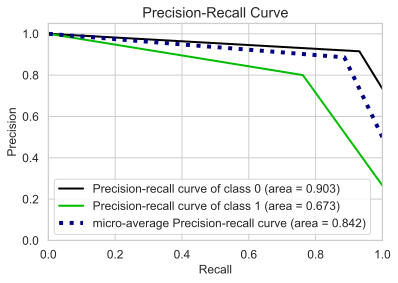

In [17]:
skplt.metrics.plot_precision_recall(y_test, y_proba);
# plt.savefig('PR_Curve.svg')

### 7.3 ROC曲线

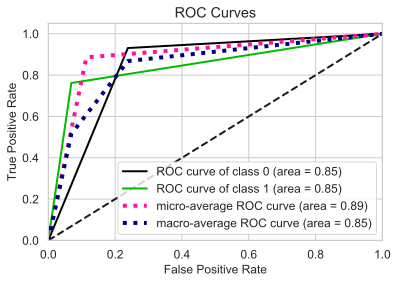

In [19]:
skplt.metrics.plot_roc(y_test, y_proba);
# plt.savefig('ROC_Curve.svg')

### 7.4 校正曲线

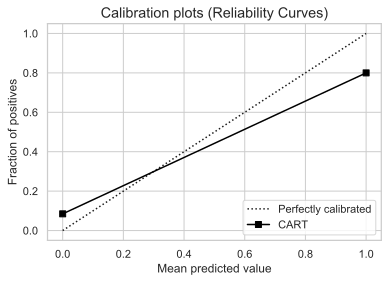

In [20]:
model_name = ['CART']
probas_list = [y_proba]
skplt.metrics.plot_calibration_curve(y_test, probas_list, model_name);
# plt.savefig('Calibration_Curve.svg')